# Redes neuronales profundas
## Global
- Carlos Moreno: 47840
- Lautaro Fernandez: 48534

##### Colab
Si ejecutamos este notebook en colab, debemos correr el siguiente script para descargar el dataset

In [56]:
# import kagglehub

# path = kagglehub.dataset_download("okarif/carla-parired-images")

# print("Path to dataset files:", path)

In [57]:
# !cp -r /root/.cache/kagglehub/datasets/okarif/carla-parired-images/versions/3/data_carla /content/data

### Imports

In [58]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from unet_18 import ResNetUNet
from unet_50 import ResNetUNet50

## Dataset

Se utiliza la clase Dataset de python para generar nuestro dataset.

In [59]:
class CarlaDataSet(Dataset):
    """
    Custom dataset for CarlaData that loads images and labels from the given directory.
    """
    def __init__(self, img_dir, transform=None, target_transform=None, train=True):
        self.day_folder = img_dir + '/day_train/' if train else img_dir + '/day_val/'
        self.night_folder = img_dir + '/night_train/' if train else img_dir + '/night_val/'
        self.img_labels = self.build_data_table()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def build_data_table(self):
        data_table = pd.DataFrame(columns=['image', 'target'])
        data_table['image'] = [self.day_folder+img for img in os.listdir(self.day_folder) ]
        data_table['target'] = [self.night_folder+img for img in os.listdir(self.night_folder) ]
        return data_table

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        lbl_path = self.img_labels.iloc[idx, 1]
        # generates 4 channels because the image is in RGBA format (png)
        image = read_image(img_path)[:3]
        label = read_image(lbl_path)[:3]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



### Transformaciones

Se realiza un resize a (224, 224) debido a que es la entrada que tienen las redes que utilizamos como encoders de nuestra UNet: Resnet18 y Resnet50.

In [60]:
SIZE_IMAGES = (224, 224)

transformations = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transformations_labels = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    transforms.Lambda(lambda x: x / 255.0)
])


### Obtener datasets y dataloaders

Se generaron dos funciones: 
- get_datasets
- get_data_iters

con la finalidad de obtener los datasets y dataloaders para luego trabajar con los datos

In [61]:
def get_datasets(img_dir: str):
  """Instantiates the datasets for training and testing

  Args:
      img_dir (str): path to the dataset

  Returns:
      tuple: (train_dataset, test_dataset)
  """
  return (CarlaDataSet(img_dir, transform=transformations, target_transform=transformations_labels, train=True),
          CarlaDataSet(img_dir, transform=transformations, target_transform=transformations_labels, train=False))

def get_data_iters(dataset_train: Dataset, dataset_test: Dataset):
  """Instantiates the data loaders for training and testing

  Args:
      dataset_train (Dataset): train dataset
      dataset_test (Dataset): test dataset

  Returns:
        tuple: (train_loader, test_loader)
  """
  return DataLoader(dataset_train, batch_size=50, shuffle=True), DataLoader(dataset_test, batch_size=50, shuffle=True)

### Muestreo

In [62]:
def show_sample(dataset:CarlaDataSet, sample: int):
  """Take a sample from the dataset and shows the source image and the target

  Args:
      dataset (CarlaDataSet): Dataset object
      sample (int): index of the sample
  """
  img = Image.open(dataset.img_labels.iloc[sample, 0])
  target = Image.open(dataset.img_labels.iloc[sample, 1])

  print('sample: ', sample)

  _, axes = plt.subplots(1, 2)

  axes[0].imshow(img)
  axes[0].set_title('Image')
  axes[1].imshow(target)
  axes[1].set_title('Target')

  for ax in axes:
    ax.axis('off')

  plt.show()

In [63]:
dataset_train, dataset_val = get_datasets('../data')
data_train, data_val = get_data_iters(dataset_train, dataset_val)

sample:  210


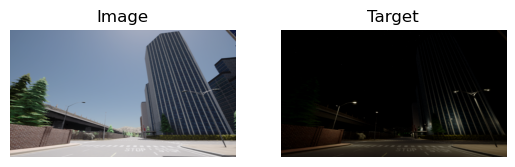

In [64]:
sample = random.randint(0, len(dataset_train))
show_sample(dataset_train,sample)

In [65]:
def desnormalize(tensor: torch.Tensor):
  """Desnormalize a tensor to be able to plot it

  Args:
      tensor (torch.Tensor): tensor to desnormalize
  
  Returns:
      torch.Tensor: desnormalized tensor
  """
  tensor = tensor.to('cuda')
  mean = torch.tensor([0.485, 0.456, 0.406], device='cuda:0').view(3, 1, 1)
  std = torch.tensor([0.229, 0.224, 0.225], device='cuda:0').view(3, 1, 1)
  output_tensor = tensor * std + mean
  output_tensor = torch.clamp(output_tensor, 0, 1)
  output_tensor = (output_tensor * 255).byte()
  return output_tensor


def plot_tensor(tensor: torch.Tensor, des=False):
  """Plot a tensor

  Args:
      tensor (torch.Tensor): tensor to plot
      des (bool, optional): if the tensor is desnormalized. Defaults to False.
  """
  if des:
    tensor = desnormalize(tensor).to('cpu')
  tensor = tensor.permute(1, 2, 0)
  # tensor = desnormalize(tensor)
  plt.imshow(tensor)
  plt.show()

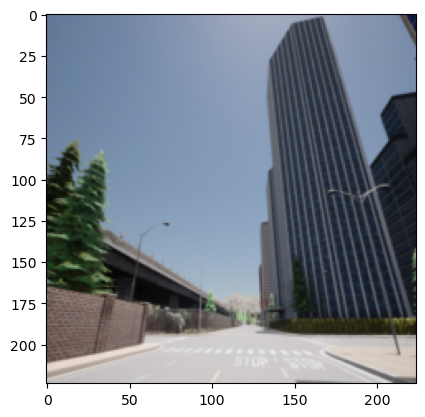

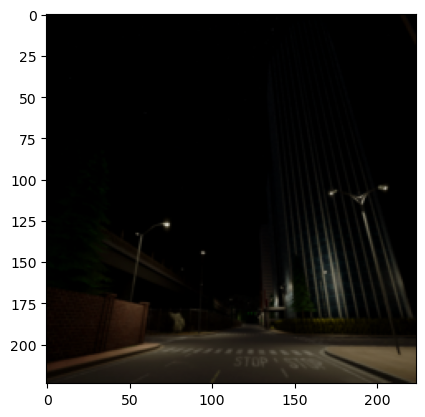

In [66]:
plot_tensor(dataset_train[sample][0], des=True)
plot_tensor(dataset_train[sample][1])

### Observando la normalizacion

In [67]:
def scatter_plot_three_channels(rgb_image, title: str):
    """
    Create a 3D scatter plot of the RGB channels of an image.

    Parameters:
    - rgb_image: A tensor or NumPy array of shape (C, H, W) or (H, W, C).
    - title: Title of the plot.
    """

    if isinstance(rgb_image, torch.Tensor):
        rgb_image = rgb_image.numpy()
        if rgb_image.shape[0] == 3:
            rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Convert to (H, W, C)

    # Flatten the channels
    r_values = rgb_image[..., 0].flatten()  # Red channel
    g_values = rgb_image[..., 1].flatten()  # Green channel
    b_values = rgb_image[..., 2].flatten()  # Blue channel

    # Create 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(r_values, g_values, b_values, alpha=0.5, s=1)  # Set size of points to 1 for clarity

    ax.set_title(title)
    ax.set_xlabel('Red Channel')
    ax.set_ylabel('Green Channel')
    ax.set_zlabel('Blue Channel')

    plt.show()

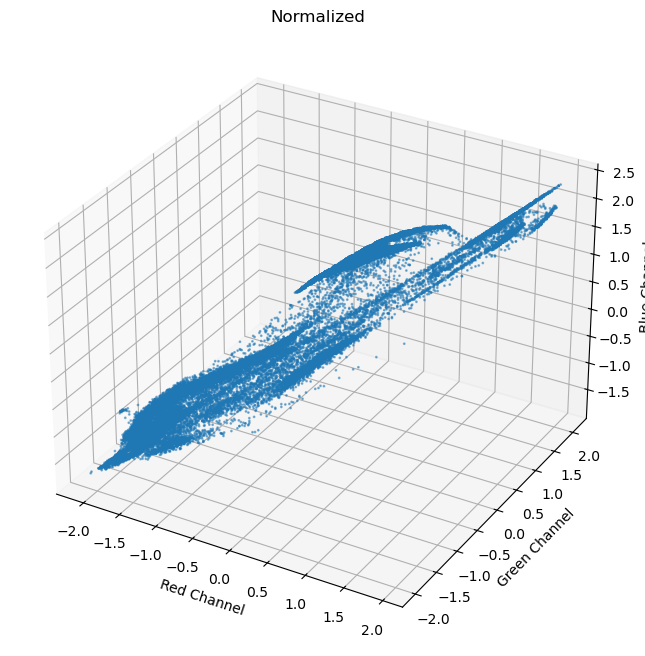

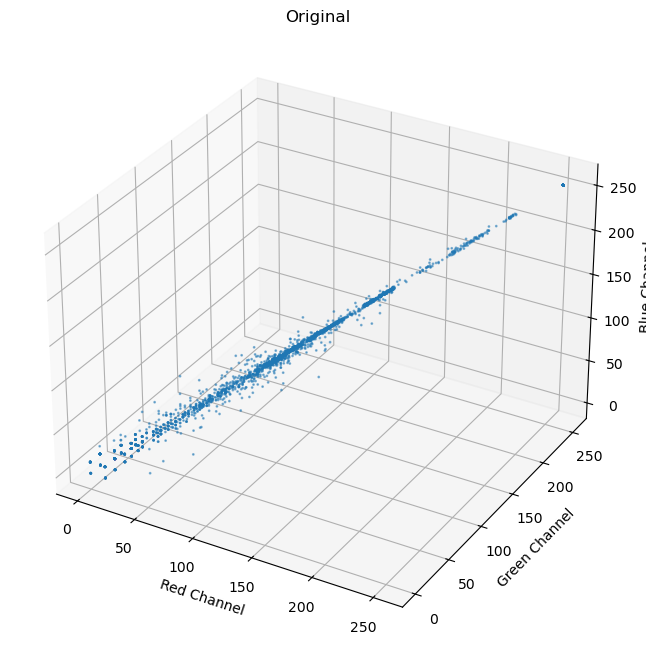

In [68]:
scatter_plot_three_channels(dataset_train[sample][0], 'Normalized')
scatter_plot_three_channels(read_image(dataset_train.img_labels.iloc[sample, 0]), 'Original')

# Model

### Entrenamiento

In [69]:
def train(model, train_data, val_data, epochs=10, lr=0.001):
    model.to('cuda')
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        params=[{
            "params":[*model.decoder.parameters(), *model.final_conv.parameters()],
            "lr":lr
          },
          {
              "params":model.encoder.parameters(),
              "lr":lr*0.01
          }], lr=lr)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (x, y) in enumerate(train_data):
            x = x.type(torch.float32).to('cuda')
            y = y.type(torch.float32).to('cuda')
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch}, loss: {train_loss}')
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y) in enumerate(val_data):
                x = x.to('cuda')
                y = y.to('cuda')
                y_hat = model(x)
                val_loss += criterion(y_hat, y)
            print(f'Epoch {epoch}, val_loss: {val_loss.item()}')

### Unet con Resnet18

En esta seccion, utilizamos una resnet18 preentrenada como encoder de nuestra unet


In [70]:
resnet18 = torchvision.models.resnet18(pretrained=True)
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18

/home/lautaro-fernandez/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lautaro-fernandez/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
for i,layer in enumerate(list(resnet18.children())[:-2]):
  print('=======================================')
  print('BLOCK', i)
  print(layer)

BLOCK 0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BLOCK 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BLOCK 2
ReLU(inplace=True)
BLOCK 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BLOCK 4
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3),

In [72]:
net = ResNetUNet(resnet18)

In [73]:
# train(net, data_train, data_val, epochs=25, lr=0.003)
# torch.save(net.state_dict(), 'model_25_normalized.pt')
# # To download the saved model file in Google Colab
# from google.colab import files
# files.download('model.pt')

In [74]:
net.load_state_dict(torch.load('../prod/model_25_normalized.pt'))

/tmp/ipykernel_36338/913285342.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('../prod/model_25_normalized.pt'))


<All keys matched successfully>

#### Observando los resultados

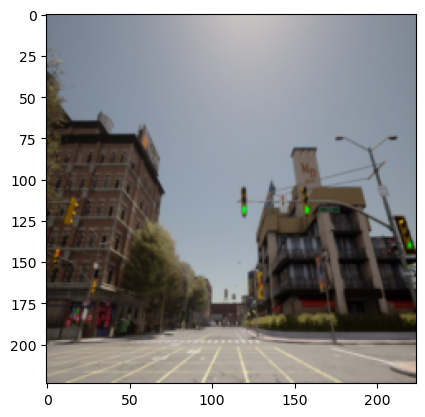

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


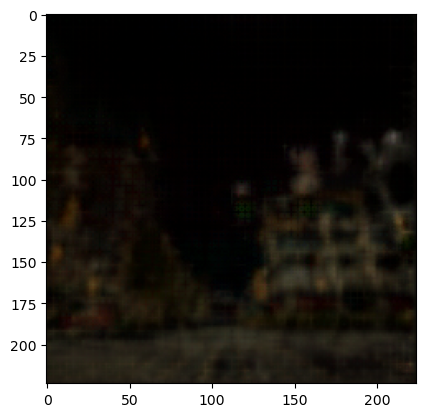

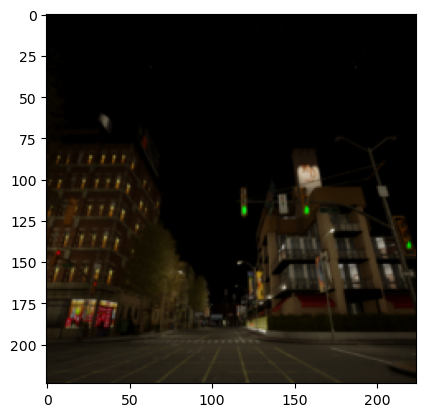

In [75]:
net.to('cuda')
net.eval()
val_sample = random.randint(0, len(dataset_val))
x = dataset_val[val_sample][0]
x = x.unsqueeze(0).to('cuda')
y = dataset_val[val_sample][1].unsqueeze(0).to('cuda')
y_hat = net(x)
plot_tensor(x[0].detach().cpu(), des=True)
plot_tensor(y_hat[0].detach().cpu())
plot_tensor(y[0].detach().cpu())

Como podemos observar, el modelo no es malo pero le falta para ser lo que buscamos. 

### Unet con Resnet50

En esta seccion, intentamos mejorar los resultados obtenidos anteriormente con una Resnet50 como encoder y sumando conexiones residuales entre la imagen de entrada y la ultima capa de nuestra red

In [76]:
resnet50 = torchvision.models.resnet50(pretrained=True)

/home/lautaro-fernandez/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
for i,layer in enumerate(list(resnet50.children())):
  print('=======================================')
  print('BLOCK', i)
  print(layer)

BLOCK 0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BLOCK 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BLOCK 2
ReLU(inplace=True)
BLOCK 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BLOCK 4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256,

In [78]:
net50 = ResNetUNet50(resnet50)

In [79]:
# net.load_state_dict(torch.load('model_20.pt'))
# train(net, data_train, data_val, epochs=60, lr=0.003)

# torch.save(net.state_dict(), 'model_50_res_60.pt')

# from google.colab import files
# files.download('model_50_res_60.pt')

In [80]:
net50.load_state_dict(torch.load('../prod/model_50_res_60.pt'))

/tmp/ipykernel_36338/102677058.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net50.load_state_dict(torch.load('../prod/model_50_res_60.pt'))


<All keys matched successfully>

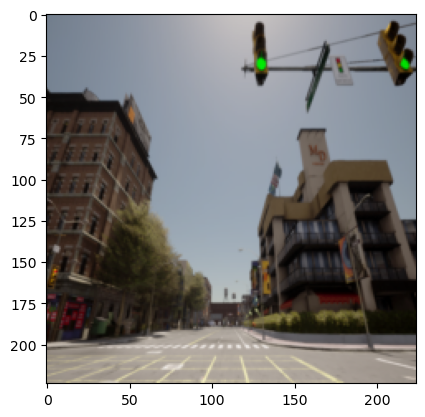

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


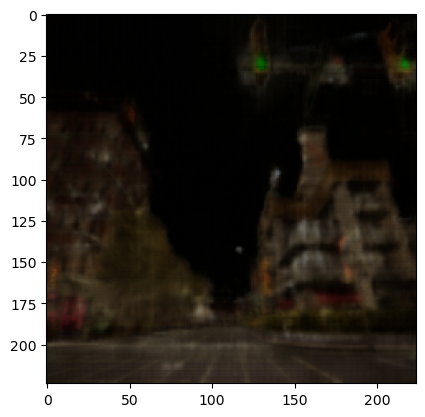

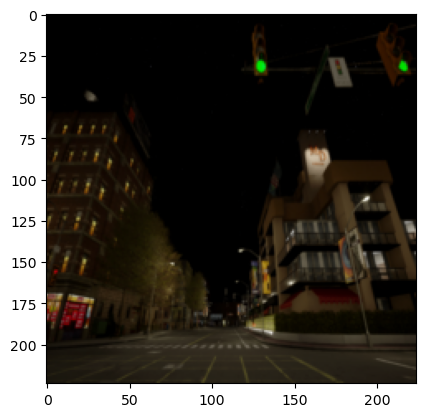

In [85]:
net50.to('cuda')
net50.eval()
val_sample = random.randint(0, len(dataset_val))
x = dataset_val[val_sample][0]
x = x.unsqueeze(0).to('cuda')
y = dataset_val[val_sample][1].unsqueeze(0).to('cuda')
y_hat = net50(x)
plot_tensor(x[0].detach().cpu(), True)
plot_tensor(y_hat[0].detach().cpu())
plot_tensor(y[0].detach().cpu())

In [89]:
def plot_test(img):
  img = transformations(img)

  img = img.unsqueeze(0).to('cuda')

  img_hat = net(img)

  plot_tensor(img[0].detach().cpu(), True)
  plot_tensor(img_hat[0].detach().cpu())

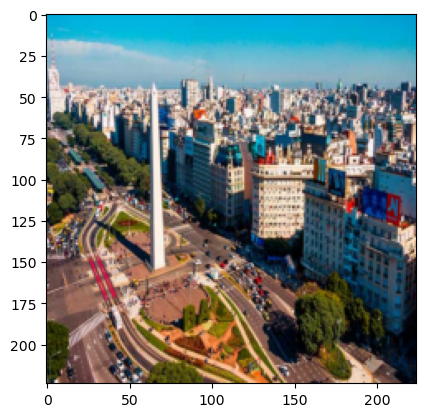

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


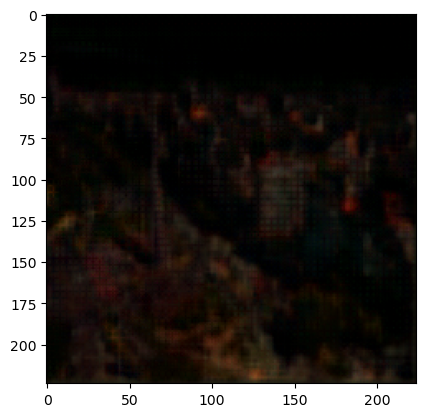

In [ ]:
img = read_image('../data/data_test/buenos_aires.jpg')
plot_test(img)

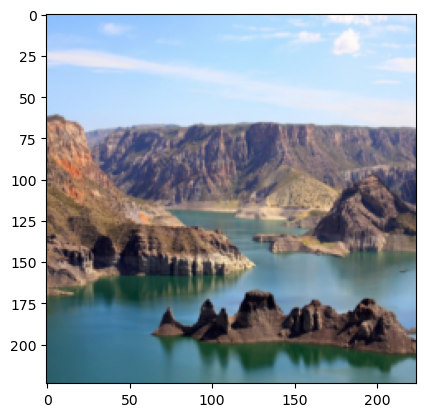

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


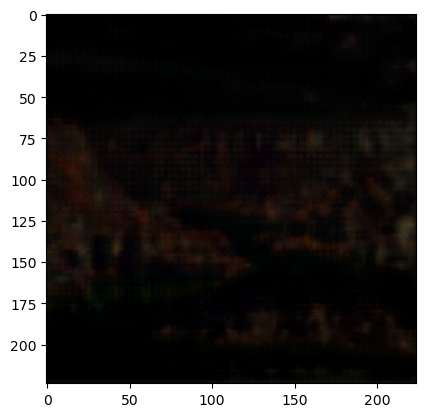

In [ ]:
img = read_image('../data/data_test/sanra.jpg')
plot_test(img)

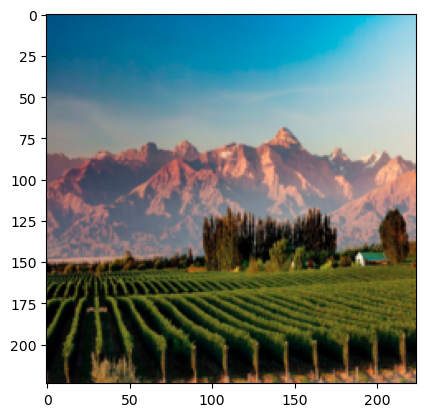

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


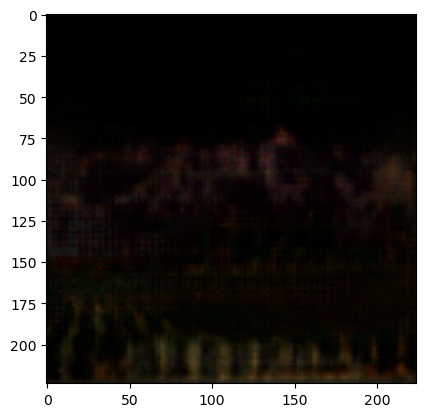

In [90]:
img = read_image('../data/data_test/mza.jpg')
plot_test(img)

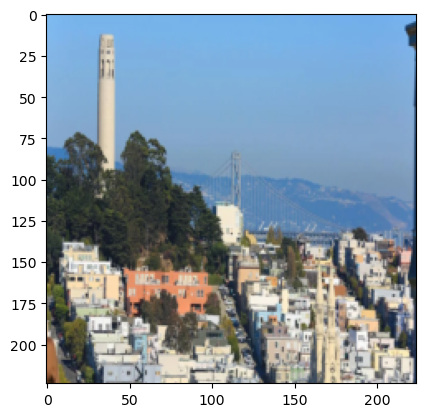

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


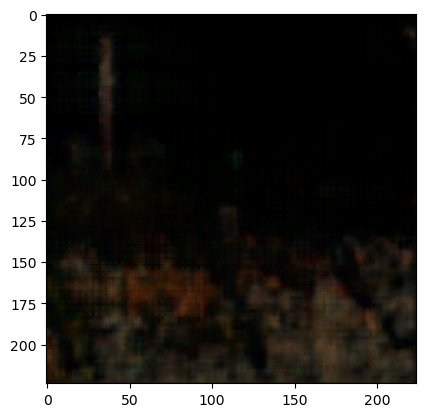